<a href="https://colab.research.google.com/github/DeathWhiff/BigData/blob/main/ML_Abgabe_SimonBurbiel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Notebook



In [11]:
!pip install mlflow
!apt-get install git
!pip install -U matplotlib
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 9.0 MB/s eta 0:00:00


## Imports

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import zipfile
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import plotly.express as px
import plotly.graph_objects as go
import shap


## Import Data from Git

In [13]:
!git clone https://github.com/DeathWhiff/Data_ML.git

fatal: destination path 'Data_ML' already exists and is not an empty directory.


## Make data accessable


In [14]:
with zipfile.ZipFile('Data_ML/data.zip', 'r') as zip_ref:
    zip_ref.extractall('Data_ML/data')

## Read the data

In [15]:
player = pd.read_csv('Data_ML/data/full_dataset_player.csv', low_memory=False)
teams = pd.read_csv('Data_ML/data/full_dataset_teams.csv', low_memory=False)
picks = pd.read_csv('Data_ML/data/full_dataset_teams_picks.csv', low_memory=False)

## Define the methods

In [19]:
def winrate_plot(data: pd.DataFrame) -> None:
    """
    Function to show the winrate of the blue and red side.
    Parameters
    ----------
    data : pandas.DataFrame
        Dataframe with the data to predict.
    
    Returns
    -------
    None
    
    """
    # group the data by side and get average winrate
    data = data.groupby('teamId').mean().reset_index()
    # create the plot
    fig = go.Figure(data=[go.Pie(labels=['Blue Side', 'Red Side'], values=[data['win'][0], data['win'][1]], hole=.3)])
    fig.update_layout(title_text="Winrate of the Blue and Red Side")
    fig.show()

       
def vis_games_overall(data):
    """
    Visualizes the average games played per player.

    Parameters
    ----------
    data : pandas.DataFrame
        The data to visualize.

    Returns
    -------
    None
        Displays a bar plot of the average games played per player.
    """
    # count each number inside the column games_played_player
    count = data['games_played_player'].value_counts()

    # visualize the data
    plt.bar(count.index, count.values)
    plt.title('Average Games Played per Player')
    # lower y axis to 0
    plt.ylim(0, 11000)
    plt.xlabel('Games Played')
    plt.ylabel('Players')
    plt.show()
    

def vis_game_length(data):
    """
    Visualizes the average game length.

    Parameters
    ----------
    data : pandas.DataFrame
        The data to visualize.

    Returns
    -------
    None
        Displays a bar plot of the average game length.
    """
    # make a plot from the dots that you select as a middle of a quantil
    plt.bar(['0-25%', '25-50%', '50-75%', '75-100%'], [data['gameDuration'].quantile(0.2), data['gameDuration'].quantile(0.4), data['gameDuration'].quantile(0.6), data['gameDuration'].quantile(0.8)])
    plt.title('Average Game Length')
    plt.xlabel('Quantil')
    plt.ylabel('Game Length')
    plt.show()


def model_predict(modelnr, data):
    """
    Function to predict the win of a game.
    Parameters
    ----------
    modelnr : number
        Number of the model to load.
    data : pandas.DataFrame
        Dataframe with the data to predict.
    
    Returns
    -------
    None
    
    """
    model_string = "model"+str(modelnr)
    best_model = mlflow.sklearn.load_model(f'Data_ML/best_models/{model_string}')
    X_train_val, X_test, y_train_val, y_test = train_test_split(data.drop('win', axis=1), data['win'], test_size=0.2, random_state=1)
    predictions = best_model.predict(X_test)
    model_accuracy = accuracy_score(y_test ,predictions)
    print ("Accuracy   Score : ",model_accuracy,"\n")
    vis_accuracy(y_test, predictions)
    
# make the errors visible as plot
def vis_accuracy(y, y_pred):
    """
    Visualizes the accuracy score of a model.

    Parameters
    ----------
    y : pd.Series
        The target variable.
    y_pred : pd.Series
        The predicted target variable.

    Returns
    -------
    None
        Displays a bar plot of alpha, beta and right predictions, and prints the accuracy score.
    """
    # Calculate alpha, beta, and no error counts
    # make y as list
    y = y.tolist()
    y_pred = y_pred.tolist()
    alpha = 0
    beta = 0
    no_error = 0
    for i in range(len(y)):
        if y[i] == 1 and y_pred[i] == 0:
            alpha += 1
        elif y[i] == 0 and y_pred[i] == 1:
            beta += 1
        else:
            no_error += 1
    
    # Display a bar plot of alpha, beta and no error counts
    plt.bar(['Alpha-Error', 'Beta-Error','Right Prediction'], [alpha, beta, no_error], color=['black', 'red', 'green'])
    plt.title('Alpha and Beta Errors')
    plt.xlabel('Prediction')
    plt.ylabel('Count')
    plt.legend()
    plt.show()
    
    # Calculate accuracy score
    accuracy = accuracy_score(y, y_pred)
    
    print('Accuracy: ', accuracy)

def get_model_importance_plot(modelnr, data):
    """
    Function to get the importance plot of a model.
    Parameters
    ----------
    modelnr : number
        Number of the model to load.
    data : pandas.DataFrame
        Dataframe with the data to predict.
    
    Returns
    -------
    None
    
    """
    model_string = "model"+str(modelnr)
    # load the model
    best_model = mlflow.sklearn.load_model(f'Data_ML/best_models/{model_string}')
    # split the data like always
    X_train_val, X_test, y_train_val, y_test = train_test_split(data.drop('win', axis=1), data['win'], test_size=0.2, random_state=1)
    # show the importance plot
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_train_val)
    shap.summary_plot(shap_values, X_train_val, plot_type="bar")

In [20]:
winrate_plot(player)

The winrate of the blue team is a little higher

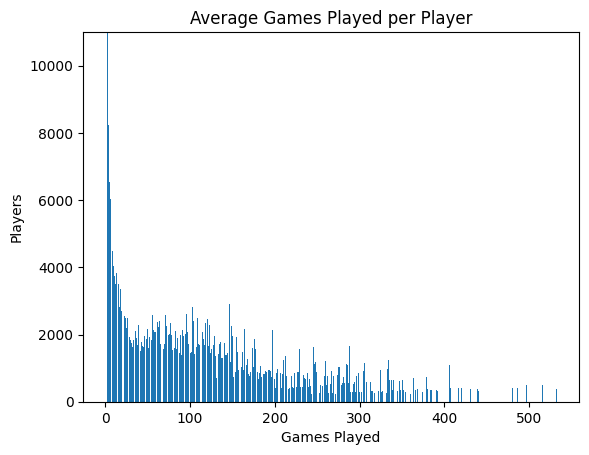

In [21]:
vis_games_overall(player)

The most players play less then 200 games per year ranked

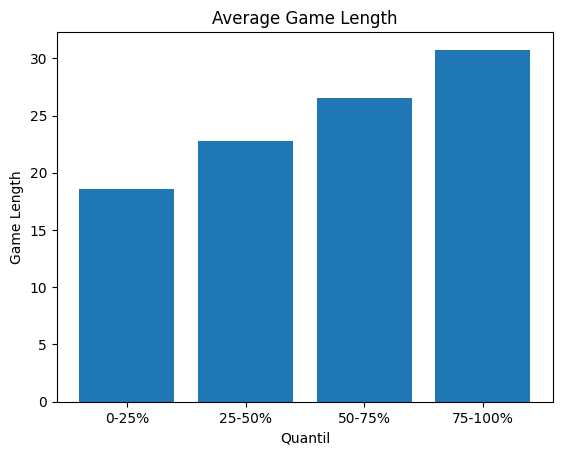

In [22]:
vis_game_length(player)

With this quantils of game length we can see that a game is average 25 min, that means that the most playing players play 5 percent of the hours of one year ranked (even more with casual games so they could play more then 4 hours each day professional)

In [23]:
player = player.drop('gameId', axis=1)
player = player.drop('gameDuration', axis=1)
player = player.drop('gameDuration_on_champion', axis=1)
teams = teams.drop('gameDuration_on_champion_x', axis=1)
teams = teams.drop('gameDuration_on_champion_y', axis=1)

## Run the prediction

Accuracy   Score :  0.6155222850082671 



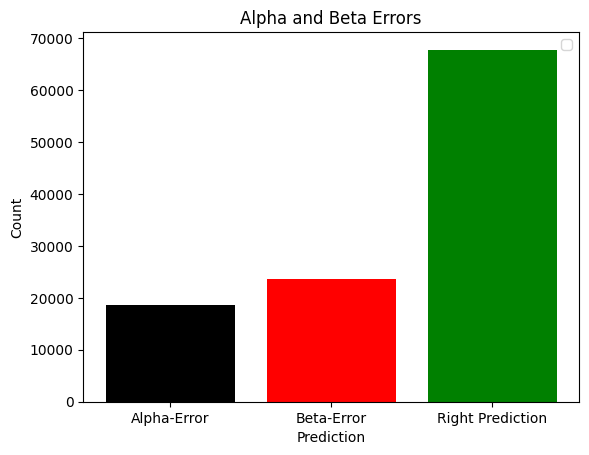

Accuracy:  0.6155222850082671


In [24]:
model_predict(1, player)

Accuracy   Score :  0.7593568313953488 



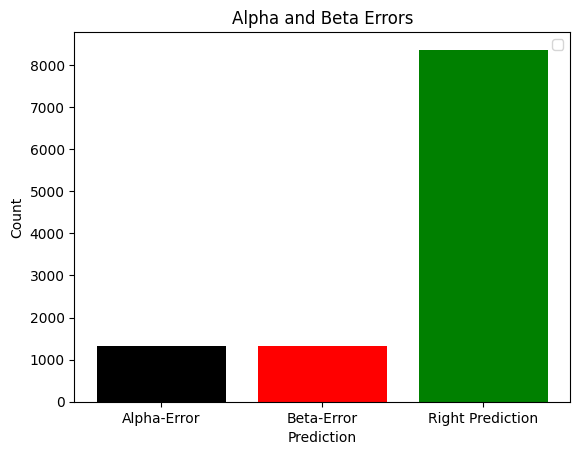

Accuracy:  0.7593568313953488


In [25]:
model_predict(2, teams)

Accuracy   Score :  0.5386991279069767 



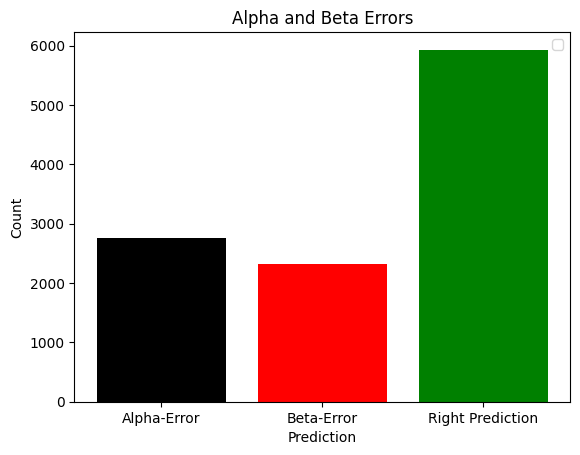

Accuracy:  0.5386991279069767


In [26]:
model_predict(3, picks)

## Feature Importance

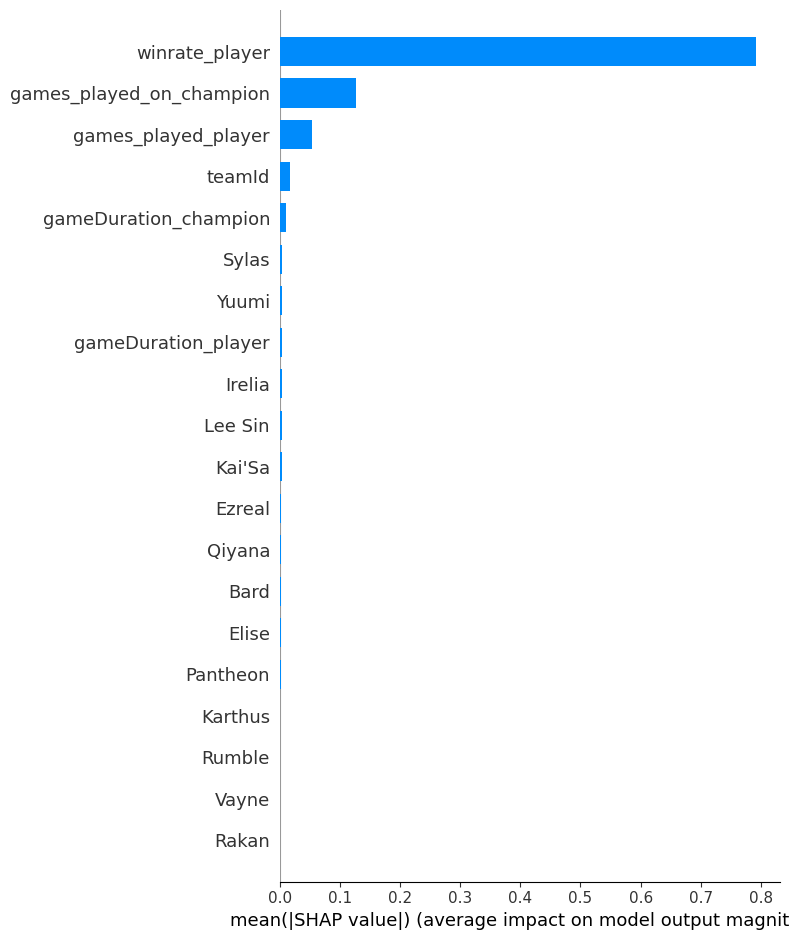

In [27]:
get_model_importance_plot(1, player)

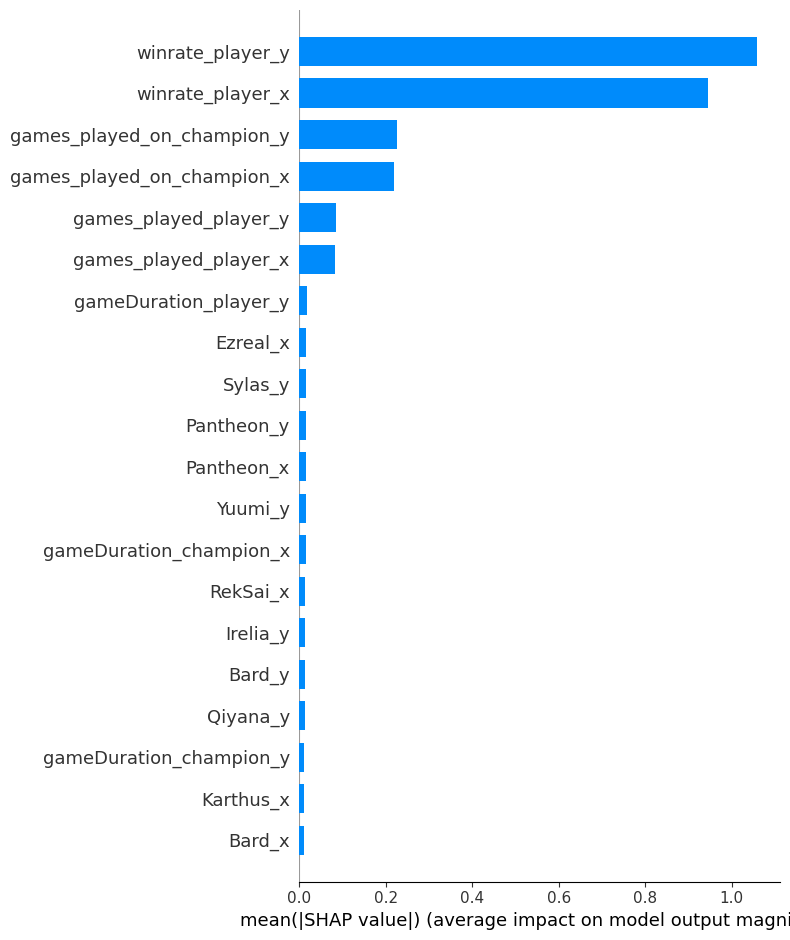

In [28]:
get_model_importance_plot(2, teams)

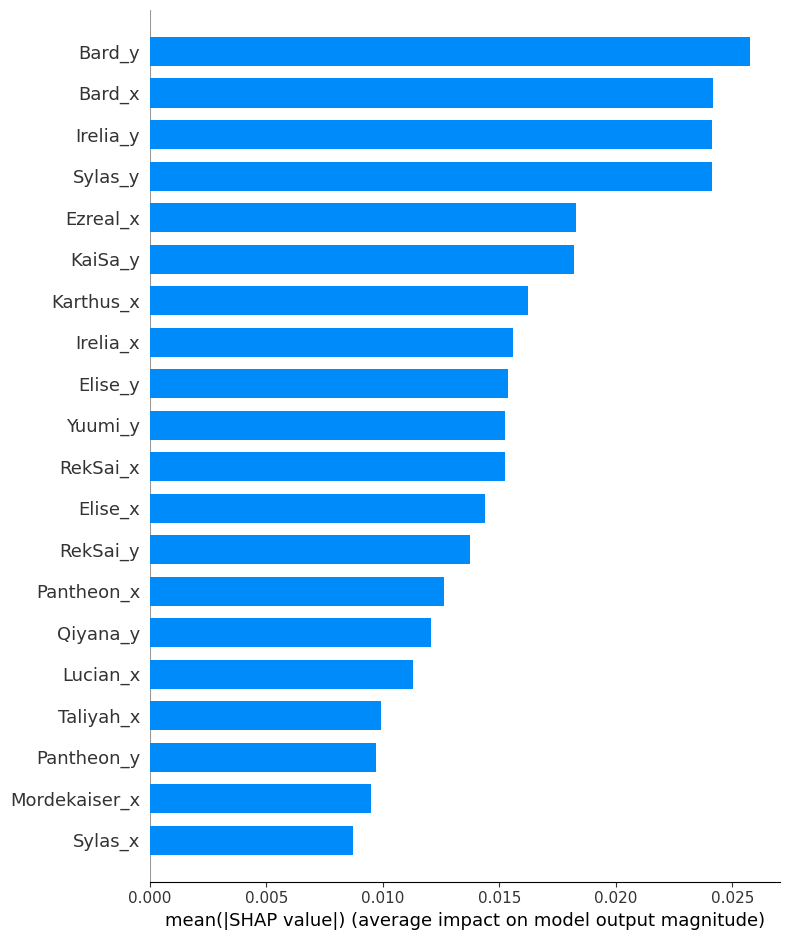

In [29]:
get_model_importance_plot(3, picks)